In [4]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import nibabel as nib
import skimage
from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.integrate as integrate
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from multiprocessing import Pool
import dill as pickle
from pathos.multiprocessing import ProcessingPool as Pool
warnings.filterwarnings("ignore")

In [5]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]

In [62]:
# Flat the vector
t1 = t1_slice.flatten()
t2 = t2_slice.flatten()

In [58]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

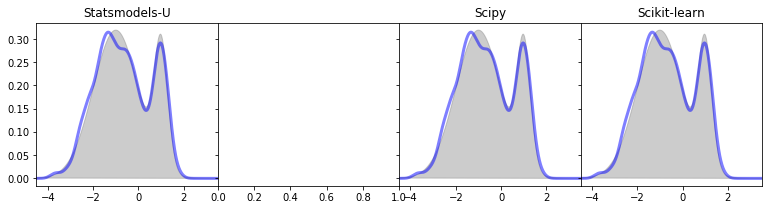

In [59]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    try:
        pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
        ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
        ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
        ax[i].set_title(kde_funcnames[i])
        ax[i].set_xlim(-4.5, 3.5)
    except:
        continue
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

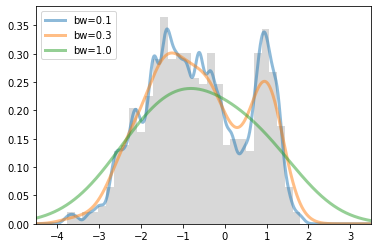

In [60]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')
plt.show()

In [61]:
dens_u = KDEMultivariate(data=[t1,t2],
                         var_type='cc', bw='normal_reference')

In [63]:
kde = KernelDensity(kernel='epanechnikov', algorithm='ball_tree',bandwidth=0.2).fit(np.array([t1,t2]).transpose())